In [4]:
import pandas as pd

# Load a small sample of the dataset to inspect structure
file_path = "cleaned_data.csv"
df = pd.read_csv(file_path, nrows=10)  # Load only 5 rows for quick inspection

# Display all column names and the first few rows
print("Column Names:", df.columns.tolist())
print(df.head())

# Check the max days that can be used
df_full = pd.read_csv(file_path, usecols=['starttime', 'endtime'])  # Load only required columns
max_days = (df_full['endtime'].max() - df_full['starttime'].min())

print(f"\nMax possible TOTAL_DAYS based on data: {max_days:.2f} days")

Column Names: ['vmId', 'tenantId', 'vmTypeId', 'priority', 'starttime', 'endtime', 'id', 'machineId', 'core', 'memory', 'hdd', 'ssd', 'nic']
      vmId  tenantId  vmTypeId  priority  starttime   endtime    id  \
0  2259459    544990        17         0   6.912037  6.918943    18   
1  2259459    544990        17         0   6.912037  6.918943   289   
2  2259459    544990        17         0   6.912037  6.918943   586   
3  2259459    544990        17         0   6.912037  6.918943   826   
4  2259459    544990        17         0   6.912037  6.918943  1017   

   machineId      core    memory  hdd       ssd     nic  
0          1  0.208333  0.177778  0.0  0.006871  0.0025  
1          3  0.500000  0.195312  0.0  0.007828  0.0025  
2          6  0.833333  0.520833  0.0  0.023483  0.0025  
3          8  0.416667  0.260417  0.0  0.007828  0.0020  
4          9  0.416667  0.173611  0.0  0.007828  0.0020  

Max possible TOTAL_DAYS based on data: 90.01 days


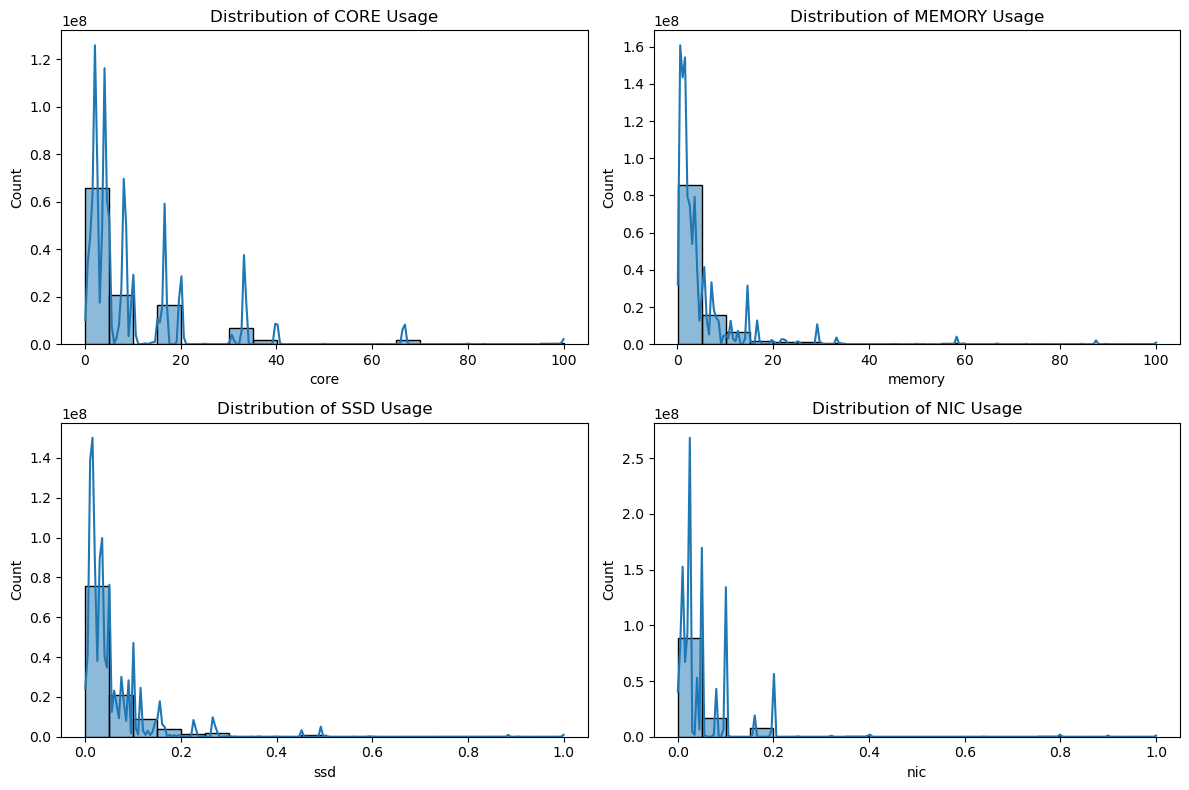

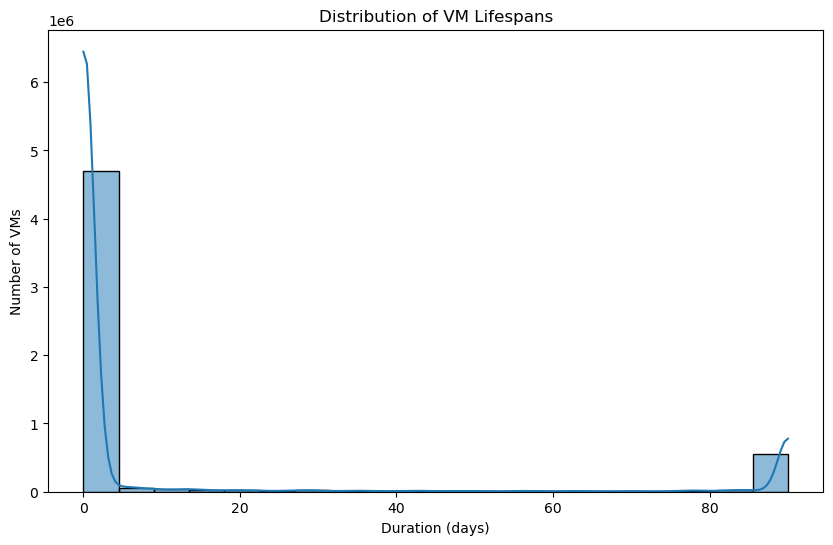

<Figure size 1400x700 with 0 Axes>

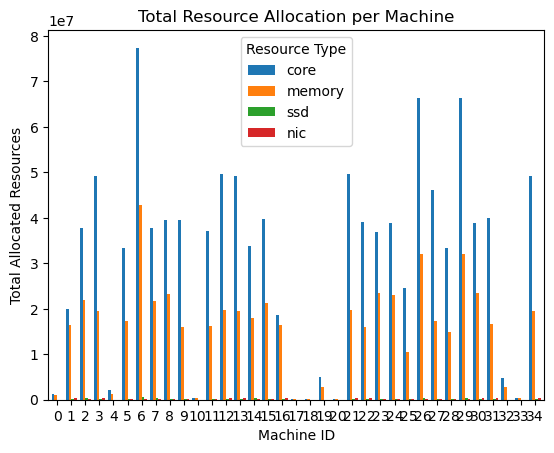

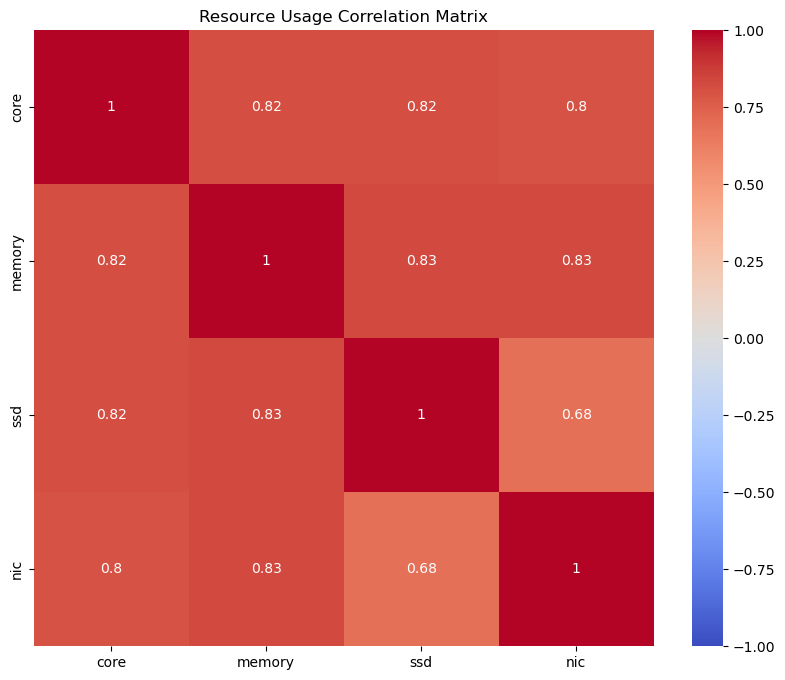

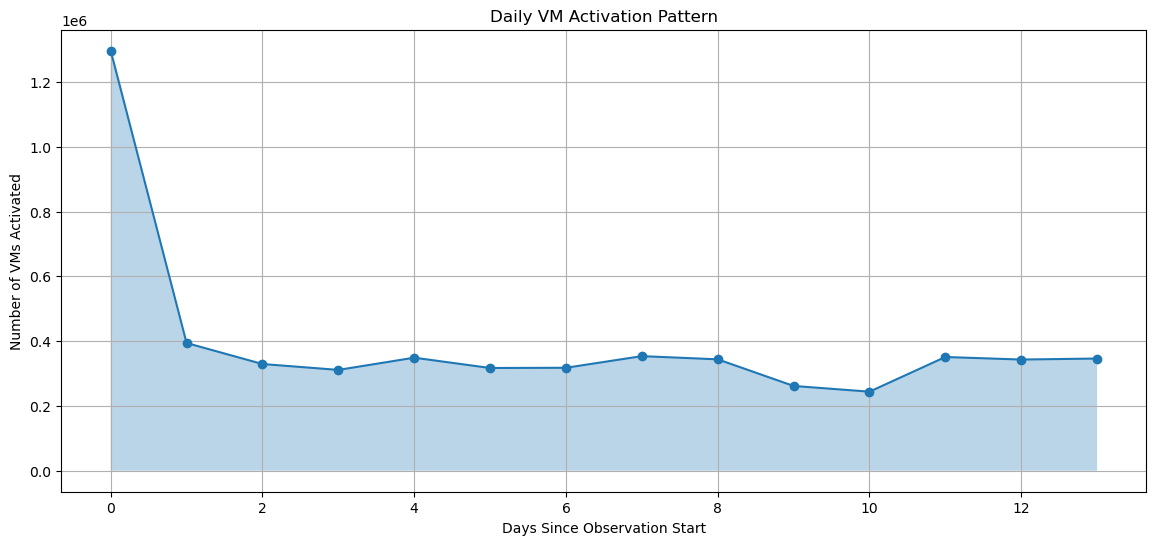

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset here as 'df'
df = pd.read_csv('cleaned_data.csv')

# Visualization 1: Resource Utilization Distributions
plt.figure(figsize=(12, 8))
resources = ['core', 'memory', 'ssd', 'nic']
for i, col in enumerate(resources, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col.upper()} Usage')
plt.tight_layout()
plt.show()

# Visualization 2: VM Duration Analysis
unique_vms = df.drop_duplicates('vmId').copy()
unique_vms['duration'] = unique_vms['endtime'] - unique_vms['starttime']

plt.figure(figsize=(10, 6))
sns.histplot(unique_vms['duration'], kde=True, bins=20)
plt.title('Distribution of VM Lifespans')
plt.xlabel('Duration (days)')
plt.ylabel('Number of VMs')
plt.show()

# Visualization 3: Machine Resource Allocation
machine_resources = df.groupby('machineId')[['core', 'memory', 'ssd', 'nic']].sum()

plt.figure(figsize=(14, 7))
machine_resources.plot(kind='bar', width=0.8)
plt.title('Total Resource Allocation per Machine')
plt.xlabel('Machine ID')
plt.ylabel('Total Allocated Resources')
plt.legend(title='Resource Type')
plt.xticks(rotation=0)
plt.show()

# Visualization 4: Resource Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[['core', 'memory', 'ssd', 'nic']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Resource Usage Correlation Matrix')
plt.show()

# Visualization 5: VM Activation Timeline
unique_vms = df.drop_duplicates('vmId').copy()
unique_vms['start_day'] = np.floor(unique_vms['starttime']).astype(int)
daily_counts = unique_vms['start_day'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
plt.fill_between(daily_counts.index, daily_counts.values, alpha=0.3)
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-')
plt.title('Daily VM Activation Pattern')
plt.xlabel('Days Since Observation Start')
plt.ylabel('Number of VMs Activated')
plt.grid(True)
plt.show()

2025-03-06 15:39:26,785 - INFO - Loading first 3000000 rows from cleaned_data.csv...
2025-03-06 15:39:27,763 - INFO - Loaded 3000000 rows
2025-03-06 15:39:27,772 - INFO - Preprocessing data...
2025-03-06 15:39:50,584 - INFO - Splitting data into train and test sets...
2025-03-06 15:39:50,584 - INFO - Generating Naive Forecast...
2025-03-06 15:39:50,586 - INFO - Naive Forecast Evaluation:
2025-03-06 15:39:50,586 - INFO -   - MAE: 385.568
2025-03-06 15:39:50,586 - INFO -   - RMSE: 1431.799
2025-03-06 15:39:50,586 - INFO -   - R² Score: 0.999


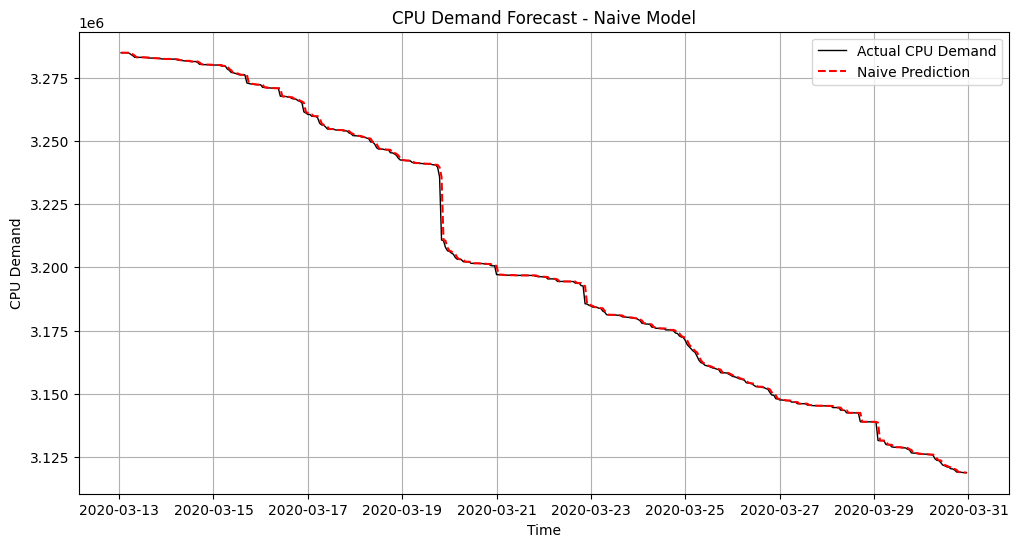

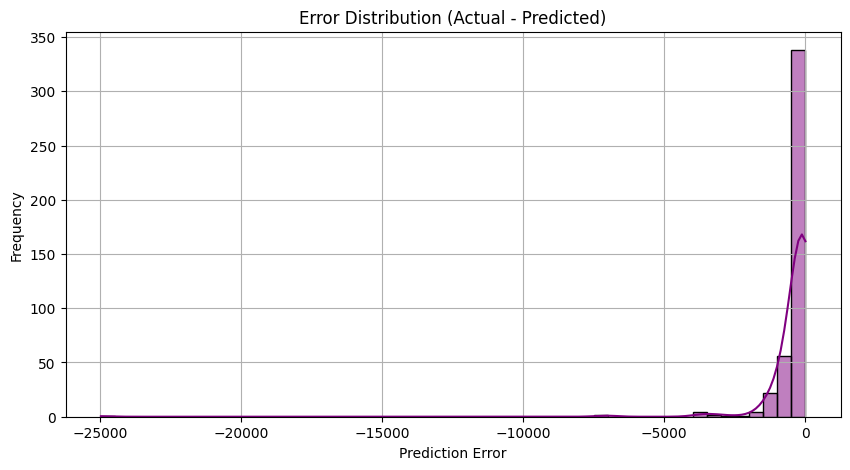

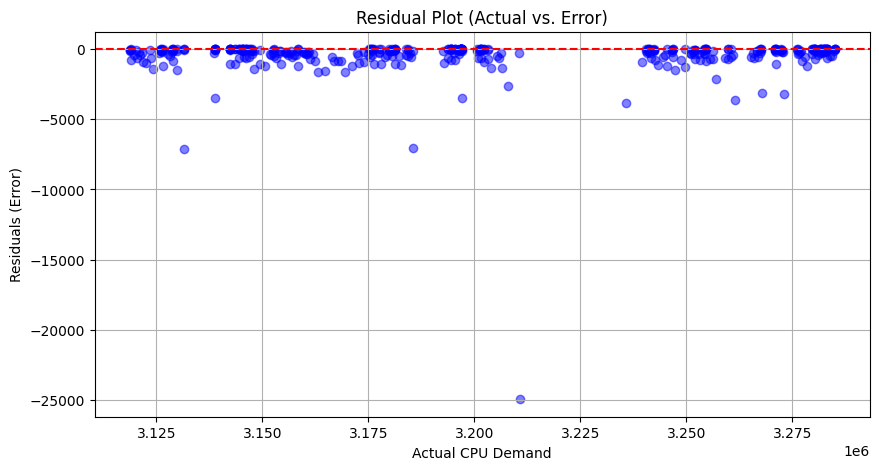

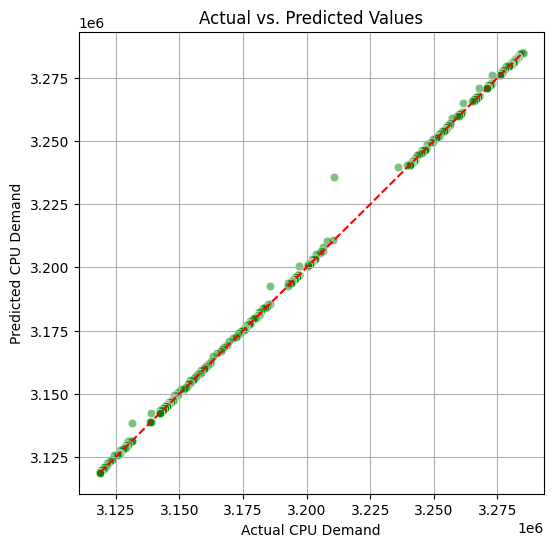

In [6]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Configuration
SAMPLE_SIZE = 3000000  # Number of rows to load
TOTAL_DAYS = 90        # Total days of data

# Load Data
def load_data(file_path, sample_size):
    logging.info(f"Loading first {sample_size} rows from {file_path}...")
    data = pd.read_csv(file_path, nrows=sample_size)
    logging.info(f"Loaded {len(data)} rows")
    return data

# Preprocess Data
def preprocess_data(data):
    logging.info("Preprocessing data...")
    
    # Convert time values
    data['starttime'] = pd.to_numeric(data['starttime'], errors='coerce').fillna(0)
    data['endtime'] = pd.to_numeric(data['endtime'], errors='coerce').fillna(TOTAL_DAYS)
    data['start_hour'] = (data['starttime'] * 24).clip(0, TOTAL_DAYS * 24).astype(int)
    data['end_hour'] = (data['endtime'] * 24).clip(0, TOTAL_DAYS * 24).astype(int)
    
    # Generate hourly time index
    total_hours = TOTAL_DAYS * 24
    time_index = pd.date_range(start="2020-01-01", periods=total_hours, freq='h')
    
    # Initialize demand arrays
    cpu_demand = np.zeros(total_hours)
    
    # Aggregate CPU demand
    for _, row in data.iterrows():
        start, end = int(row['start_hour']), int(row['end_hour'])
        if 0 <= start < end <= total_hours:
            cpu_demand[start:end] += row['core']
    
    # Create DataFrame
    df = pd.DataFrame({'cpu': cpu_demand}, index=time_index)
    
    return df

# Train-Test Split
def split_data(data):
    logging.info("Splitting data into train and test sets...")
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    return train, test

# Naive Forecasting
def naive_forecast(train, test):
    logging.info("Generating Naive Forecast...")
    predictions = test['cpu'].shift(1).dropna()
    actuals = test['cpu'].loc[predictions.index]
    return predictions.values, actuals.values, test.loc[predictions.index]

# Evaluate Model
def evaluate_model(predictions, actuals):
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    
    logging.info(f"Naive Forecast Evaluation:")
    logging.info(f"  - MAE: {mae:.3f}")
    logging.info(f"  - RMSE: {rmse:.3f}")
    logging.info(f"  - R² Score: {r2:.3f}")
    
    return mae, rmse, r2

# Visualization: Original vs. Forecasted
def plot_results(test, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test['cpu'], label="Actual CPU Demand", color='black', linewidth=1)
    plt.plot(test.index[:len(predictions)], predictions, label="Naive Prediction", linestyle="--", color='red')
    plt.xlabel("Time")
    plt.ylabel("CPU Demand")
    plt.title("CPU Demand Forecast - Naive Model")
    plt.legend()
    plt.grid()
    plt.show()

# Visualization: Error Distribution
def plot_error_distribution(errors):
    plt.figure(figsize=(10, 5))
    sns.histplot(errors, bins=50, kde=True, color='purple')
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title("Error Distribution (Actual - Predicted)")
    plt.grid()
    plt.show()

# Visualization: Residual Plot
def plot_residuals(actuals, predictions):
    residuals = actuals - predictions
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, residuals, alpha=0.5, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual CPU Demand")
    plt.ylabel("Residuals (Error)")
    plt.title("Residual Plot (Actual vs. Error)")
    plt.grid()
    plt.show()

# Visualization: Actual vs. Predicted Scatter Plot
def plot_actual_vs_predicted(actuals, predictions):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=actuals, y=predictions, color='green', alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], color='red', linestyle="--")
    plt.xlabel("Actual CPU Demand")
    plt.ylabel("Predicted CPU Demand")
    plt.title("Actual vs. Predicted Values")
    plt.grid()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Load data
    file_path = "cleaned_data.csv"  # Replace with your actual file path
    raw_data = load_data(file_path, SAMPLE_SIZE)

    # Preprocess data
    processed_data = preprocess_data(raw_data)

    # Split data
    train, test = split_data(processed_data)

    # Run Naive Forecast
    naive_preds, naive_actuals, test_filtered = naive_forecast(train, test)

    # Evaluate & Plot Results
    evaluate_model(naive_preds, naive_actuals)
    
    # Visualizations
    plot_results(test_filtered, naive_preds)  # Time series actual vs. predicted
    plot_error_distribution(naive_actuals - naive_preds)  # Error distribution
    plot_residuals(naive_actuals, naive_preds)  # Residuals plot
    plot_actual_vs_predicted(naive_actuals, naive_preds)  # Scatter plot (Actual vs. Predicted)

2025-03-06 16:14:26,411 - INFO - Loading first 3000000 rows from cleaned_data.csv...
2025-03-06 16:14:27,390 - INFO - Loaded 3000000 rows with 13 columns
2025-03-06 16:14:27,399 - INFO - Preprocessing data with resource tracking...
2025-03-06 16:14:50,357 - INFO - Splitting data into train and test sets...
2025-03-06 16:14:50,357 - INFO - Generating Naive Forecast...
2025-03-06 16:14:50,358 - INFO - Naive Forecast Evaluation:
2025-03-06 16:14:50,358 - INFO -   - MAE: 385.568
2025-03-06 16:14:50,358 - INFO -   - RMSE: 1431.799
2025-03-06 16:14:50,358 - INFO -   - R² Score: 0.999
2025-03-06 16:14:50,379 - INFO - Rendering simulation video...
2025-03-06 16:14:50,379 - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-03-06 16:14:50,380 - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1600x800 -pix_fmt rgba -framerate 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y cpu_demand_simulation.mp4
2025-03-06 16:16:19,325 

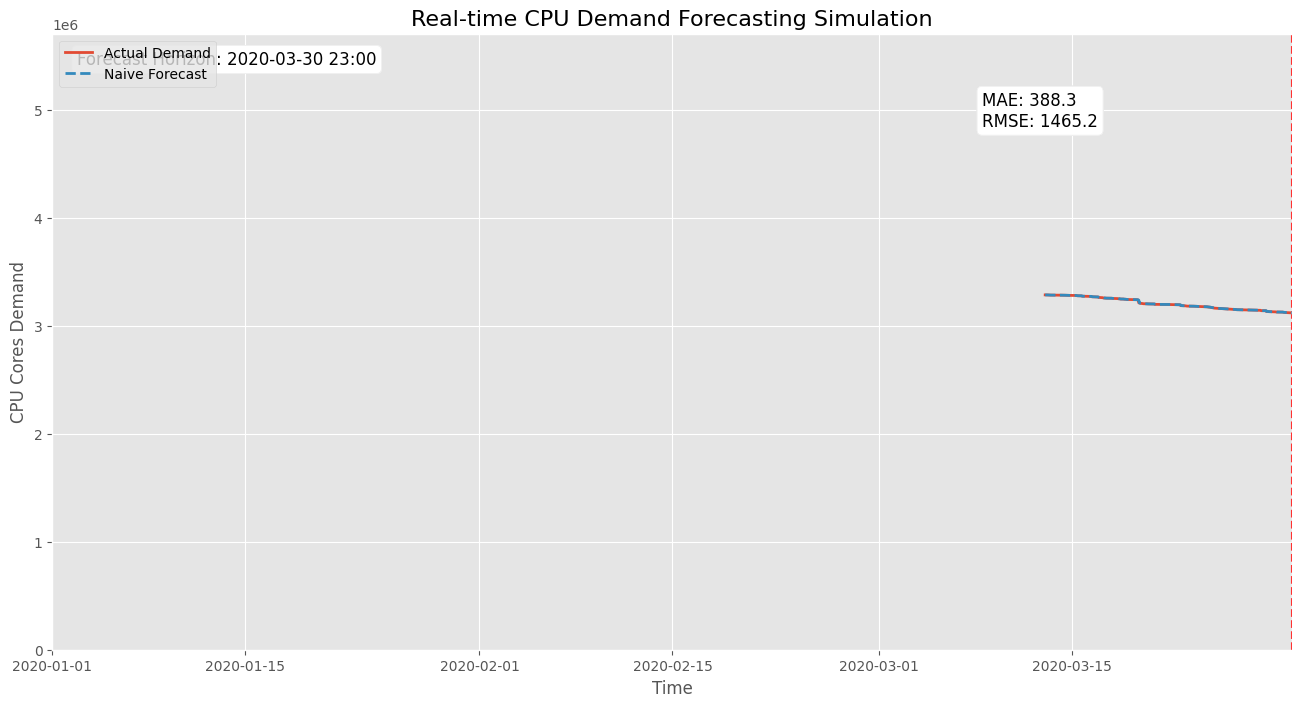

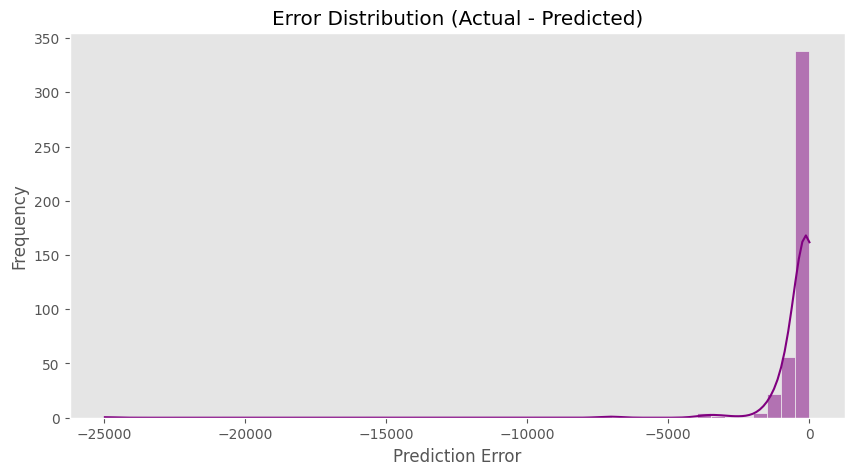

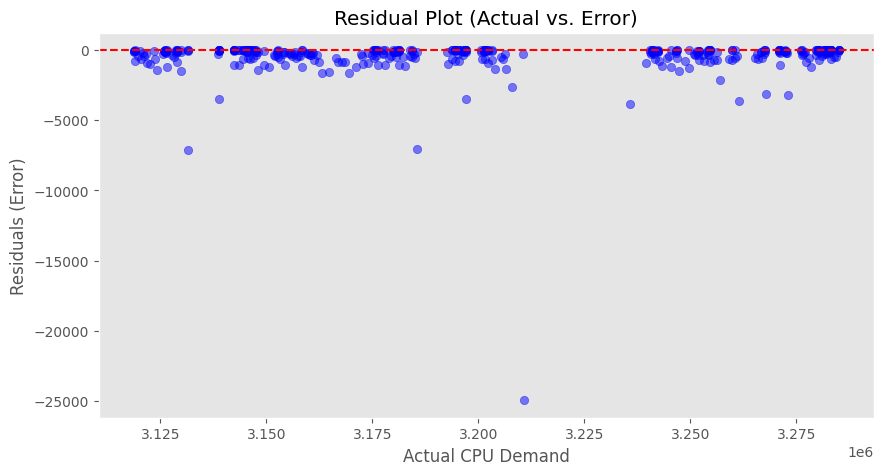

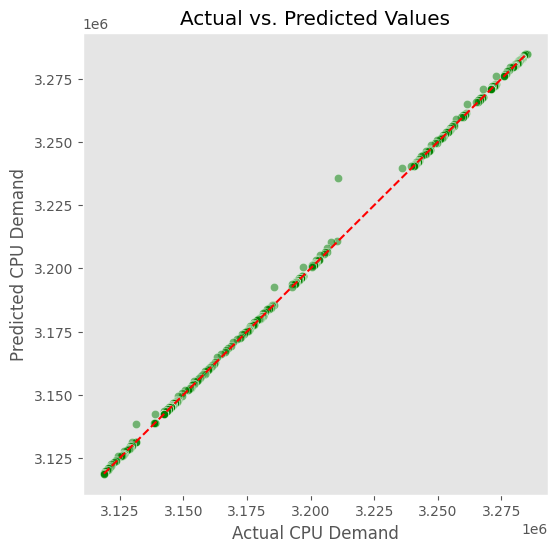

2025-03-06 16:16:19,782 - INFO - All outputs generated successfully!


In [16]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import logging

# Configuration
SAMPLE_SIZE = 3000000
TOTAL_DAYS = 90
VIDEO_PATH = "cpu_demand_simulation.mp4"

def create_forecast_animation(train, test, predictions, output_path):
    plt.style.use('ggplot')  # Simplified style
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Basic animation setup
    ax.set_title("CPU Demand Forecast")
    ax.set_xlabel("Time")
    ax.set_ylabel("CPU Cores")
    
    actual_line, = ax.plot([], [], label='Actual')
    pred_line, = ax.plot([], [], label='Forecast', linestyle='--')
    ax.legend()
    
    def animate(i):
        actual_line.set_data(test.index[:i+1], test['cpu'].values[:i+1])
        pred_line.set_data(test.index[:i+1], predictions[:i+1])
        return actual_line, pred_line
    
    # Save with FFmpeg (now works after installation)
    anim = FuncAnimation(fig, animate, frames=len(test), interval=100)
    anim.save(VIDEO_PATH, writer='ffmpeg', fps=15)
    logging.info(f"Video saved to {VIDEO_PATH}")

# Keep all other functions identical to your original code
# [load_data, preprocess_data, split_data, naive_forecast, etc.]

if __name__ == "__main__":
    raw_data = load_data("cleaned_data.csv", SAMPLE_SIZE)
    processed_data = preprocess_data(raw_data)
    train, test = split_data(processed_data)
    preds, actuals, test_filtered = naive_forecast(train, test)
    create_forecast_animation(train, test_filtered, preds, VIDEO_PATH)